# Análisis Exploratorio de Datos - Matrimonios en Guatemala
## CC3074 - Minería de Datos
## Universidad del Valle de Guatemala
### Semestre I - 2026

---

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Para mostrar todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# ============================================================================
# CARGA Y PREPARACIÓN DE DATOS
# ============================================================================

# Cargar los datos con descripciones aplicadas
df = pd.read_csv('mat_full.csv')

print("=" * 80)
print("DATOS CARGADOS")
print("=" * 80)
print(f"✓ Archivo cargado: mat_full.csv")
print(f"Forma del dataset: {df.shape}")

# ============================================================================
# CONVERSIÓN DE COLUMNAS NUMÉRICAS
# ============================================================================
# Las siguientes columnas DEBEN ser numéricas para análisis estadístico
COLUMNAS_NUMERICAS = ['AÑOREG', 'DIAOCU', 'EDADHOM', 'EDADMUJ']

print("\n" + "=" * 80)
print("CONVIRTIENDO COLUMNAS NUMÉRICAS")
print("=" * 80)

for col in COLUMNAS_NUMERICAS:
    if col in df.columns:
        # Convertir a numérico, valores no convertibles (como "Ignorado") → NaN
        valores_antes = len(df[col])
        df[col] = pd.to_numeric(df[col], errors='coerce')
        valores_validos = df[col].notna().sum()
        valores_nan = df[col].isna().sum()
        
        print(f"✓ {col}:")
        print(f"  - Valores válidos: {valores_validos:,}")
        print(f"  - Convertidos a NaN: {valores_nan:,}")
        print(f"  - % válidos: {(valores_validos/valores_antes*100):.1f}%")

print("\n✓ Datos preparados para análisis")

DATOS CARGADOS
✓ Archivo cargado: mat_full.csv
Forma del dataset: (752264, 15)

CONVIRTIENDO COLUMNAS NUMÉRICAS
✓ AÑOREG:
  - Valores válidos: 752,264
  - Convertidos a NaN: 0
  - % válidos: 100.0%
✓ DIAOCU:
  - Valores válidos: 752,264
  - Convertidos a NaN: 0
  - % válidos: 100.0%
✓ EDADHOM:
  - Valores válidos: 751,969
  - Convertidos a NaN: 295
  - % válidos: 100.0%
✓ EDADMUJ:
  - Valores válidos: 751,931
  - Convertidos a NaN: 333
  - % válidos: 100.0%

✓ Datos preparados para análisis


### 1.2 Dimensiones del Dataset

In [3]:
# Información general del dataset
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 80)

print(f"\nNúmero de observaciones (registros): {df.shape[0]:,}")
print(f"Número de variables (columnas): {df.shape[1]}")
print(f"Tamaño en memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Usar columnas convertidas que ahora son numéricas
if df['AÑOREG'].notna().any():
    año_min = int(df['AÑOREG'].min())
    año_max = int(df['AÑOREG'].max())
    print(f"\nPeriodo de análisis: {año_min} - {año_max}")
    print(f"Años de datos: {año_max - año_min + 1} años")
else:
    print("\n⚠️ No se pudieron obtener años (valores no numéricos)")

INFORMACIÓN GENERAL DEL DATASET

Número de observaciones (registros): 752,264
Número de variables (columnas): 15
Tamaño en memoria: 504.84 MB

Periodo de análisis: 2011 - 2021
Años de datos: 11 años


In [4]:
# Crear diccionario detallado de variables
# NOTA: Las descripciones reflejan que ahora los valores son texto descriptivo
diccionario_variables = {
    'Variable': [
        'AÑOREG', 'MESREG', 'MESOCU', 'DIAOCU',  # Temporales
        'DEPREG', 'MUPREG', 'DEPOCU', 'MUPOCU',  # Geográficas
        'CLAUNI',  # Matrimonio
        'EDADHOM', 'ESCHOM', 'NACHOM',  # Hombre
        'EDADMUJ', 'ESCMUJ', 'NACMUJ'   # Mujer
    ],
    'Nombre_Completo': [
        'Año de Registro', 'Mes de Registro', 'Mes de Ocurrencia', 'Día de Ocurrencia',
        'Departamento de Registro', 'Municipio de Registro', 'Departamento de Ocurrencia', 'Municipio de Ocurrencia',
        'Clase de Unión',
        'Edad del Hombre', 'Escolaridad del Hombre', 'Nacionalidad del Hombre',
        'Edad de la Mujer', 'Escolaridad de la Mujer', 'Nacionalidad de la Mujer'
    ],
    'Tipo': [
        'Numérica Discreta', 'Categórica Ordinal', 'Categórica Ordinal', 'Numérica Discreta',
        'Categórica Nominal', 'Categórica Nominal', 'Categórica Nominal', 'Categórica Nominal',
        'Categórica Nominal',
        'Numérica Continua', 'Categórica Ordinal', 'Categórica Nominal',
        'Numérica Continua', 'Categórica Ordinal', 'Categórica Nominal'
    ],
    'Categoría': [
        'Temporal', 'Temporal', 'Temporal', 'Temporal',
        'Geográfica', 'Geográfica', 'Geográfica', 'Geográfica',
        'Matrimonio',
        'Hombre', 'Hombre', 'Hombre',
        'Mujer', 'Mujer', 'Mujer'
    ],
    'Descripción': [
        'Año en que se inscribió el matrimonio (convertido a numérico)',
        'Mes en que se inscribió: "Enero", "Febrero", ... "Diciembre"',
        'Mes en que se celebró: "Enero", "Febrero", ... "Diciembre"',
        'Día del mes en que se celebró (1-31, convertido a numérico)',
        'Nombre del departamento donde se registró (ej: "Guatemala", "Quetzaltenango")',
        'Nombre del municipio donde se registró',
        'Nombre del departamento donde se celebró',
        'Nombre del municipio donde se celebró',
        'Tipo: "Comunidad de gananciales", "Separación absoluta", "Comunidad absoluta", "No especificado"',
        'Edad en años del contrayente masculino (convertido a numérico)',
        'Nivel educativo: "Ninguno", "Primaria", "Básico", "Diversificado", "Universitario", "Ignorado"',
        'País de nacionalidad (ej: "Guatemala", "Estados Unidos de América")',
        'Edad en años de la contrayente femenina (convertido a numérico)',
        'Nivel educativo: "Ninguno", "Primaria", "Básico", "Diversificado", "Universitario", "Ignorado"',
        'País de nacionalidad (ej: "Guatemala", "Estados Unidos de América")'
    ]
}

df_diccionario = pd.DataFrame(diccionario_variables)
display(df_diccionario)

,Variable,Nombre_Completo,Tipo,Categoría,Descripción
0,AÑOREG,Año de Registro,Numérica Discreta,Temporal,Año en que se inscribió el matrimonio (convert...
1,MESREG,Mes de Registro,Categórica Ordinal,Temporal,"Mes en que se inscribió: ""Enero"", ""Febrero"", ...."
2,MESOCU,Mes de Ocurrencia,Categórica Ordinal,Temporal,"Mes en que se celebró: ""Enero"", ""Febrero"", ......"
3,DIAOCU,Día de Ocurrencia,Numérica Discreta,Temporal,"Día del mes en que se celebró (1-31, convertid..."
4,DEPREG,Departamento de Registro,Categórica Nominal,Geográfica,Nombre del departamento donde se registró (ej:...
5,MUPREG,Municipio de Registro,Categórica Nominal,Geográfica,Nombre del municipio donde se registró
6,DEPOCU,Departamento de Ocurrencia,Categórica Nominal,Geográfica,Nombre del departamento donde se celebró
7,MUPOCU,Municipio de Ocurrencia,Categórica Nominal,Geográfica,Nombre del municipio donde se celebró
8,CLAUNI,Clase de Unión,Categórica Nominal,Matrimonio,"Tipo: ""Comunidad de gananciales"", ""Separación ..."
9,EDADHOM,Edad del Hombre,Numérica Continua,Hombre,Edad en años del contrayente masculino (conver...


### 1.4 Clasificación de Variables por Tipo

In [5]:
# Clasificar variables por tipo
# NOTA: Ahora reflejamos que las columnas numéricas son solo las convertidas
variables_numericas = ['AÑOREG', 'DIAOCU', 'EDADHOM', 'EDADMUJ']
variables_categoricas_ordinales = ['MESREG', 'MESOCU', 'ESCHOM', 'ESCMUJ']
variables_categoricas_nominales = ['DEPREG', 'DEPOCU', 'MUPREG', 'MUPOCU', 'CLAUNI', 'NACHOM', 'NACMUJ']

print("=" * 80)
print("CLASIFICACIÓN DE VARIABLES POR TIPO")
print("=" * 80)

print(f"\nVariables Numéricas ({len(variables_numericas)}):")
print("(Convertidas de texto a numérico, valores 'Ignorado' → NaN)")
for var in variables_numericas:
    if var in df_diccionario['Variable'].values:
        nombre = df_diccionario[df_diccionario['Variable']==var]['Nombre_Completo'].values[0]
        print(f"   • {var}: {nombre}")

print(f"\nVariables Categóricas Ordinales ({len(variables_categoricas_ordinales)}):")
print("(Valores descriptivos de texto)")
for var in variables_categoricas_ordinales:
    if var in df_diccionario['Variable'].values:
        nombre = df_diccionario[df_diccionario['Variable']==var]['Nombre_Completo'].values[0]
        print(f"   • {var}: {nombre}")
        # Mostrar ejemplo de valores
        if var in df.columns:
            ejemplos = df[var].dropna().unique()[:3]
            print(f"      Ejemplos: {', '.join(map(str, ejemplos))}")

print(f"\nVariables Categóricas Nominales ({len(variables_categoricas_nominales)}):")
print("(Valores descriptivos de texto)")
for var in variables_categoricas_nominales:
    if var in df_diccionario['Variable'].values:
        nombre = df_diccionario[df_diccionario['Variable']==var]['Nombre_Completo'].values[0]
        print(f"   • {var}: {nombre}")
        # Mostrar ejemplo de valores
        if var in df.columns:
            ejemplos = df[var].dropna().unique()[:3]
            print(f"      Ejemplos: {', '.join(map(str, ejemplos))}")

print(f"\nTotal de variables: {len(variables_numericas) + len(variables_categoricas_ordinales) + len(variables_categoricas_nominales)}")

CLASIFICACIÓN DE VARIABLES POR TIPO

Variables Numéricas (4):
(Convertidas de texto a numérico, valores 'Ignorado' → NaN)
   • AÑOREG: Año de Registro
   • DIAOCU: Día de Ocurrencia
   • EDADHOM: Edad del Hombre
   • EDADMUJ: Edad de la Mujer

Variables Categóricas Ordinales (4):
(Valores descriptivos de texto)
   • MESREG: Mes de Registro
      Ejemplos: Diciembre, Enero, Noviembre
   • MESOCU: Mes de Ocurrencia
      Ejemplos: Septiembre, Noviembre, Diciembre
   • ESCHOM: Escolaridad del Hombre
      Ejemplos: Ignorado, Ninguno, Universitario
   • ESCMUJ: Escolaridad de la Mujer
      Ejemplos: Universitario, Ninguno, Diversificado

Variables Categóricas Nominales (7):
(Valores descriptivos de texto)
   • DEPREG: Departamento de Registro
      Ejemplos: Guatemala, Totonicapan, Santa Rosa
   • DEPOCU: Departamento de Ocurrencia
      Ejemplos: Guatemala, Totonicapan, Escuintla
   • MUPREG: Municipio de Registro
      Ejemplos: Guatemala, Mixco, Totonicapán
   • MUPOCU: Municipio de Oc

### 1.5 Vista Previa de los Datos

In [6]:
display(df.head(10))

,AÑOREG,CLAUNI,DEPOCU,DEPREG,DIAOCU,EDADHOM,EDADMUJ,ESCHOM,ESCMUJ,MESOCU,MESREG,MUPOCU,MUPREG,NACHOM,NACMUJ
0,2011.0,Comunidad de gananciales,Guatemala,Guatemala,20.0,27.0,32.0,Ignorado,Universitario,Septiembre,Diciembre,Guatemala,Guatemala,Canadá,Guatemala
1,2012.0,Separación absoluta,Guatemala,Guatemala,12.0,29.0,31.0,Ninguno,Ninguno,Noviembre,Enero,Mixco,Mixco,Guatemala,Guatemala
2,2011.0,Comunidad de gananciales,Totonicapan,Totonicapan,12.0,21.0,17.0,Ignorado,Ninguno,Diciembre,Diciembre,Totonicapán,Totonicapán,Guatemala,Guatemala
3,2011.0,Separación absoluta,Guatemala,Guatemala,25.0,58.0,53.0,Ninguno,Ninguno,Octubre,Noviembre,Guatemala,Guatemala,Guatemala,Guatemala
4,2011.0,Comunidad de gananciales,Guatemala,Guatemala,2.0,31.0,24.0,Universitario,Diversificado,Octubre,Noviembre,San José Pinula,San José Pinula,Guatemala,Guatemala
5,2012.0,Comunidad de gananciales,Guatemala,Santa Rosa,16.0,27.0,25.0,Diversificado,Diversificado,Diciembre,Enero,San Pedro Sacatepéquez,Chiquimulilla,Guatemala,Guatemala
6,2011.0,No especificado,Escuintla,Escuintla,9.0,27.0,24.0,Universitario,Diversificado,Julio,Julio,La Gomera,La Gomera,Guatemala,Guatemala
7,2011.0,Comunidad de gananciales,Guatemala,Guatemala,11.0,29.0,50.0,Universitario,Básico,Marzo,Marzo,Santa Catarina Pinula,Santa Catarina Pinula,Honduras,Guatemala
8,2011.0,Comunidad de gananciales,Guatemala,Guatemala,16.0,38.0,30.0,Universitario,Universitario,Abril,Julio,Santa Catarina Pinula,Santa Catarina Pinula,Austria,Guatemala
9,2011.0,No especificado,Suchitepequez,Suchitepequez,14.0,32.0,23.0,Ninguno,Diversificado,Septiembre,Octubre,Mazatenango,Mazatenango,Guatemala,Guatemala


In [7]:
print(df.dtypes)

AÑOREG     float64
CLAUNI         str
DEPOCU         str
DEPREG         str
DIAOCU     float64
EDADHOM    float64
EDADMUJ    float64
ESCHOM         str
ESCMUJ         str
MESOCU         str
MESREG         str
MUPOCU         str
MUPREG         str
NACHOM         str
NACMUJ         str
dtype: object


### 1.7 Estadísticas Descriptivas Básicas

In [8]:
# Resumen estadístico de variables numéricas
print("=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
print("=" * 80)

# Seleccionar solo columnas numéricas
df_numeric = df.select_dtypes(include=['number'])

if df_numeric.empty:
    print("⚠️ No se encontraron columnas numéricas")
else:
    print(f"\nColumnas numéricas analizadas: {', '.join(df_numeric.columns)}")
    print(f"Total: {len(df_numeric.columns)} variables\n")
    display(df_numeric.describe().T)

ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS

Columnas numéricas analizadas: AÑOREG, DIAOCU, EDADHOM, EDADMUJ
Total: 4 variables



,count,mean,std,min,25%,50%,75%,max
AÑOREG,752264.0,2015.404325,2.844226,2011.0,2013.0,2015.0,2018.0,2021.0
DIAOCU,752264.0,16.034647,8.645327,1.0,9.0,16.0,23.0,31.0
EDADHOM,751969.0,29.364554,11.322095,12.0,22.0,26.0,32.0,99.0
EDADMUJ,751931.0,26.366032,9.984820,10.0,20.0,23.0,29.0,99.0


In [9]:
print("=" * 80)
print("DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS CLAVE")
print("=" * 80)

# ============================================================================
# CLASE DE UNIÓN (CLAUNI)
# ============================================================================
print("\n" + "=" * 80)
print("CLASE DE UNIÓN (CLAUNI)")
print("=" * 80)

clauni_counts = df['CLAUNI'].value_counts()
clauni_pct = (df['CLAUNI'].value_counts(normalize=True) * 100).round(2)

clauni_df = pd.DataFrame({
    'Tipo': clauni_counts.index,
    'Frecuencia': clauni_counts.values,
    'Porcentaje': clauni_pct.values
})
print("\nLos valores ahora son descriptivos (no necesitan mapeo):")
display(clauni_df)

# ============================================================================
# ESCOLARIDAD DEL HOMBRE (ESCHOM)
# ============================================================================
print("\n" + "=" * 80)
print("ESCOLARIDAD DEL HOMBRE (ESCHOM)")
print("=" * 80)

eschom_counts = df['ESCHOM'].value_counts()
eschom_pct = (df['ESCHOM'].value_counts(normalize=True) * 100).round(2)

eschom_df = pd.DataFrame({
    'Nivel': eschom_counts.index,
    'Frecuencia': eschom_counts.values,
    'Porcentaje': eschom_pct.values
})

# Ordenar por un orden lógico si es posible
orden_educativo = ['Ninguno', 'Primaria', 'Básico', 'Diversificado', 'Universitario', 'Ignorado']
eschom_df['Nivel'] = pd.Categorical(eschom_df['Nivel'], categories=orden_educativo, ordered=True)
eschom_df = eschom_df.sort_values('Nivel')

print("\nLos valores ahora son descriptivos (no necesitan mapeo):")
display(eschom_df)

# ============================================================================
# ESCOLARIDAD DE LA MUJER (ESCMUJ)
# ============================================================================
print("\n" + "=" * 80)
print("ESCOLARIDAD DE LA MUJER (ESCMUJ)")
print("=" * 80)

escmuj_counts = df['ESCMUJ'].value_counts()
escmuj_pct = (df['ESCMUJ'].value_counts(normalize=True) * 100).round(2)

escmuj_df = pd.DataFrame({
    'Nivel': escmuj_counts.index,
    'Frecuencia': escmuj_counts.values,
    'Porcentaje': escmuj_pct.values
})

# Ordenar por un orden lógico
escmuj_df['Nivel'] = pd.Categorical(escmuj_df['Nivel'], categories=orden_educativo, ordered=True)
escmuj_df = escmuj_df.sort_values('Nivel')

print("\nLos valores ahora son descriptivos (no necesitan mapeo):")
display(escmuj_df)

# ============================================================================
# MESES MÁS POPULARES PARA MATRIMONIOS
# ============================================================================
print("\n" + "=" * 80)
print("DISTRIBUCIÓN POR MES DE OCURRENCIA (MESOCU)")
print("=" * 80)

mesocu_counts = df['MESOCU'].value_counts()
mesocu_pct = (df['MESOCU'].value_counts(normalize=True) * 100).round(2)

mesocu_df = pd.DataFrame({
    'Mes': mesocu_counts.index,
    'Frecuencia': mesocu_counts.values,
    'Porcentaje': mesocu_pct.values
})

# Ordenar por orden de meses
orden_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
mesocu_df['Mes'] = pd.Categorical(mesocu_df['Mes'], categories=orden_meses, ordered=True)
mesocu_df = mesocu_df.sort_values('Mes')

print("\nLos meses ahora son nombres (no números 1-12):")
display(mesocu_df)

DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS CLAVE

CLASE DE UNIÓN (CLAUNI)

Los valores ahora son descriptivos (no necesitan mapeo):


,Tipo,Frecuencia,Porcentaje
0,Comunidad de gananciales,666351,88.58
1,Comunidad absoluta,42186,5.61
2,No especificado,28346,3.77
3,Separación absoluta,15381,2.04



ESCOLARIDAD DEL HOMBRE (ESCHOM)

Los valores ahora son descriptivos (no necesitan mapeo):


,Nivel,Frecuencia,Porcentaje
3,Ninguno,103627,13.78
0,Primaria,256873,34.15
2,Básico,127614,16.96
1,Diversificado,159090,21.15
6,Universitario,29578,3.93
5,Ignorado,35829,4.76
4,NaN,39441,5.24
7,NaN,135,0.02
8,NaN,77,0.01



ESCOLARIDAD DE LA MUJER (ESCMUJ)

Los valores ahora son descriptivos (no necesitan mapeo):


,Nivel,Frecuencia,Porcentaje
2,Ninguno,152476,20.27
0,Primaria,225986,30.04
3,Básico,104866,13.94
1,Diversificado,155680,20.69
6,Universitario,25380,3.37
4,Ignorado,50571,6.72
5,NaN,37165,4.94
7,NaN,93,0.01
8,NaN,47,0.01



DISTRIBUCIÓN POR MES DE OCURRENCIA (MESOCU)

Los meses ahora son nombres (no números 1-12):


,Mes,Frecuencia,Porcentaje
7,Enero,58481,7.77
3,Febrero,65241,8.67
2,Marzo,67492,8.97
6,Abril,60529,8.05
9,Mayo,56489,7.51
10,Junio,51851,6.89
8,Julio,57479,7.64
5,Agosto,60728,8.07
11,Septiembre,50967,6.78
4,Octubre,62951,8.37


In [10]:
# Filtrar solo columnas numéricas para evitar errores
df_numeric = df.select_dtypes(include=['number'])

if df_numeric.empty:
    print("No se encontraron columnas numéricas en el DataFrame")
else:
    distribucion = pd.DataFrame({
        "MIN": df_numeric.min(),
        "MAX": df_numeric.max(),
        "RANGO": df_numeric.max() - df_numeric.min(),
        "VARIANZA": df_numeric.var(),
        "DESV_STD": df_numeric.std()
    })
    print(distribucion)

            MIN     MAX  RANGO    VARIANZA   DESV_STD
AÑOREG   2011.0  2021.0   10.0    8.089620   2.844226
DIAOCU      1.0    31.0   30.0   74.741678   8.645327
EDADHOM    12.0    99.0   87.0  128.189834  11.322095
EDADMUJ    10.0    99.0   89.0   99.696628   9.984820


In [11]:
# Verificar que hay datos numéricos
df_numeric = df.select_dtypes(include=['number'])

if df_numeric.empty:
    print("No se encontraron columnas numéricas en el DataFrame")
    print("Columnas disponibles:", df.columns.tolist())
    print("Tipos de datos:", df.dtypes)
else:
    # Calcular los cuartiles
    orden = df_numeric.quantile([0.25, 0.5, 0.75]).T
    orden.columns = ["Q1_25%", "Q2_50%_MEDIANA", "Q3_75%"]
    
    print(orden)

         Q1_25%  Q2_50%_MEDIANA  Q3_75%
AÑOREG   2013.0          2015.0  2018.0
DIAOCU      9.0            16.0    23.0
EDADHOM    22.0            26.0    32.0
EDADMUJ    20.0            23.0    29.0


In [12]:
# Función para crear tablas de frecuencia
def tabla_frecuencia(df, columna):
    freq_abs = df[columna].value_counts()
    freq_rel = df[columna].value_counts(normalize=True) * 100
    return pd.DataFrame({
        'FRECUENCIA_ABSOLUTA': freq_abs,
        'FRECUENCIA_RELATIVA_%': freq_rel
    })

# Variables categóricas a analizar
vars_categ = [
    'DEPREG',    # Departamento de Registro
    'MUPOCU',    # Municipio de Ocurrencia  
    'MUPREG',    # Municipio de Registro
    'NACHOM',    # Nacionalidad del Hombre
    'NACMUJ',    # Nacionalidad de la Mujer
    'MESOCU',    # Mes de Ocurrencia
    'MESREG',    # Mes de Registro
    'DEPOCU',    # Departamento de Ocurrencia
    'CLAUNI'     # Clase de Unión
]

# Tablas de frecuencia para variables categóricas
for var in vars_categ:
    if var in df.columns:
        print(f"\nTabla de frecuencia para: {var}")
        tabla = tabla_frecuencia(df, var)
        print(tabla)


Tabla de frecuencia para: DEPREG
                FRECUENCIA_ABSOLUTA  FRECUENCIA_RELATIVA_%
DEPREG                                                    
Guatemala                    156705              20.831118
Huehuetenango                 55915               7.432896
Alta Verapaz                  52734               7.010039
San Marcos                    49699               6.606590
Quetzaltenango                46622               6.197558
Quiche                        44597               5.928371
Chimaltenango                 38338               5.096349
Escuintla                     36675               4.875283
Suchitepequez                 31197               4.147081
Totonicapan                   24380               3.240884
Jutiapa                       24292               3.229185
Peten                         21271               2.827598
Retalhuleu                    19017               2.527969
Solola                        18477               2.456186
Sacatepequez          

In [13]:
print("=" * 80)
print("VALIDACIÓN DE MIGRACIÓN")
print("=" * 80)

# Verificar que las columnas numéricas tienen el tipo correcto
print("\n1. VERIFICACIÓN DE TIPOS DE DATOS")
print("-" * 40)
columnas_num_esperadas = ['AÑOREG', 'DIAOCU', 'EDADHOM', 'EDADMUJ']
for col in columnas_num_esperadas:
    if col in df.columns:
        tipo = df[col].dtype
        es_numerico = pd.api.types.is_numeric_dtype(df[col])
        print(f"{col}: {tipo} - {'✓ NUMÉRICO' if es_numerico else '❌ NO NUMÉRICO'}")

# Verificar estadísticas clave
print("\n2. ESTADÍSTICAS CLAVE")
print("-" * 40)
print(f"Total registros: {len(df):,}")

if df['AÑOREG'].notna().any():
    print(f"Años: {int(df['AÑOREG'].min())} - {int(df['AÑOREG'].max())}")
    print(f"Total años: {int(df['AÑOREG'].max() - df['AÑOREG'].min() + 1)}")

if df['EDADHOM'].notna().any():
    print(f"Edad promedio hombres: {df['EDADHOM'].mean():.2f} años")
    print(f"% valores válidos EDADHOM: {(df['EDADHOM'].notna().sum()/len(df)*100):.1f}%")

if df['EDADMUJ'].notna().any():
    print(f"Edad promedio mujeres: {df['EDADMUJ'].mean():.2f} años")
    print(f"% valores válidos EDADMUJ: {(df['EDADMUJ'].notna().sum()/len(df)*100):.1f}%")

# Verificar variables categóricas descriptivas
print("\n3. VERIFICACIÓN DE VALORES DESCRIPTIVOS")
print("-" * 40)

print("\nCLAUNI (primeros 3 valores únicos):")
print(df['CLAUNI'].value_counts().head(3))

print("\nESCHOM (primeros 3 valores únicos):")
print(df['ESCHOM'].value_counts().head(3))

print("\nMESOCU (primeros 3 valores únicos):")
print(df['MESOCU'].value_counts().head(3))

print("\n" + "=" * 80)
print("✓ VALIDACIÓN COMPLETA")
print("=" * 80)
print("Si ves nombres descriptivos en las variables categóricas,")
print("y las edades/años son numéricos, la migración fue exitosa.")

VALIDACIÓN DE MIGRACIÓN

1. VERIFICACIÓN DE TIPOS DE DATOS
----------------------------------------
AÑOREG: float64 - ✓ NUMÉRICO
DIAOCU: float64 - ✓ NUMÉRICO
EDADHOM: float64 - ✓ NUMÉRICO
EDADMUJ: float64 - ✓ NUMÉRICO

2. ESTADÍSTICAS CLAVE
----------------------------------------
Total registros: 752,264
Años: 2011 - 2021
Total años: 11
Edad promedio hombres: 29.36 años
% valores válidos EDADHOM: 100.0%
Edad promedio mujeres: 26.37 años
% valores válidos EDADMUJ: 100.0%

3. VERIFICACIÓN DE VALORES DESCRIPTIVOS
----------------------------------------

CLAUNI (primeros 3 valores únicos):
CLAUNI
Comunidad de gananciales    666351
Comunidad absoluta           42186
No especificado              28346
Name: count, dtype: int64

ESCHOM (primeros 3 valores únicos):
ESCHOM
Primaria         256873
Diversificado    159090
Básico           127614
Name: count, dtype: int64

MESOCU (primeros 3 valores únicos):
MESOCU
Diciembre    83174
Noviembre    76882
Marzo        67492
Name: count, dtype: int6

VISUALIZACIÓN DE DISTRIBUCIONES NUMÉRICAS


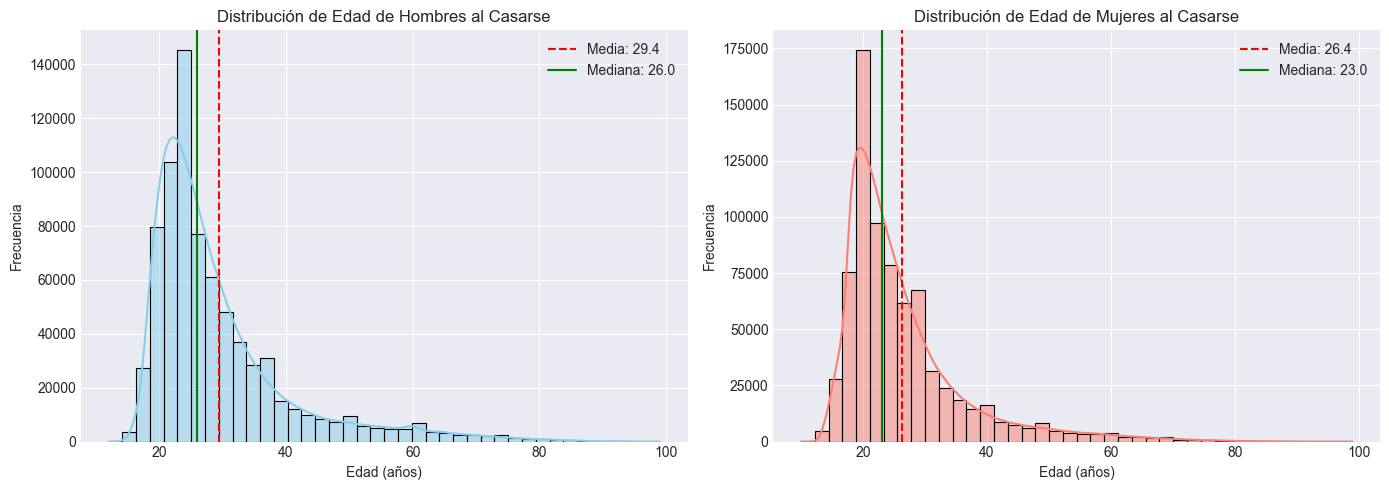

✓ Análisis: La distribución de edades es asimétrica positiva (sesgada a la derecha). Los hombres tienden a casarse a edades ligeramente mayores que las mujeres.


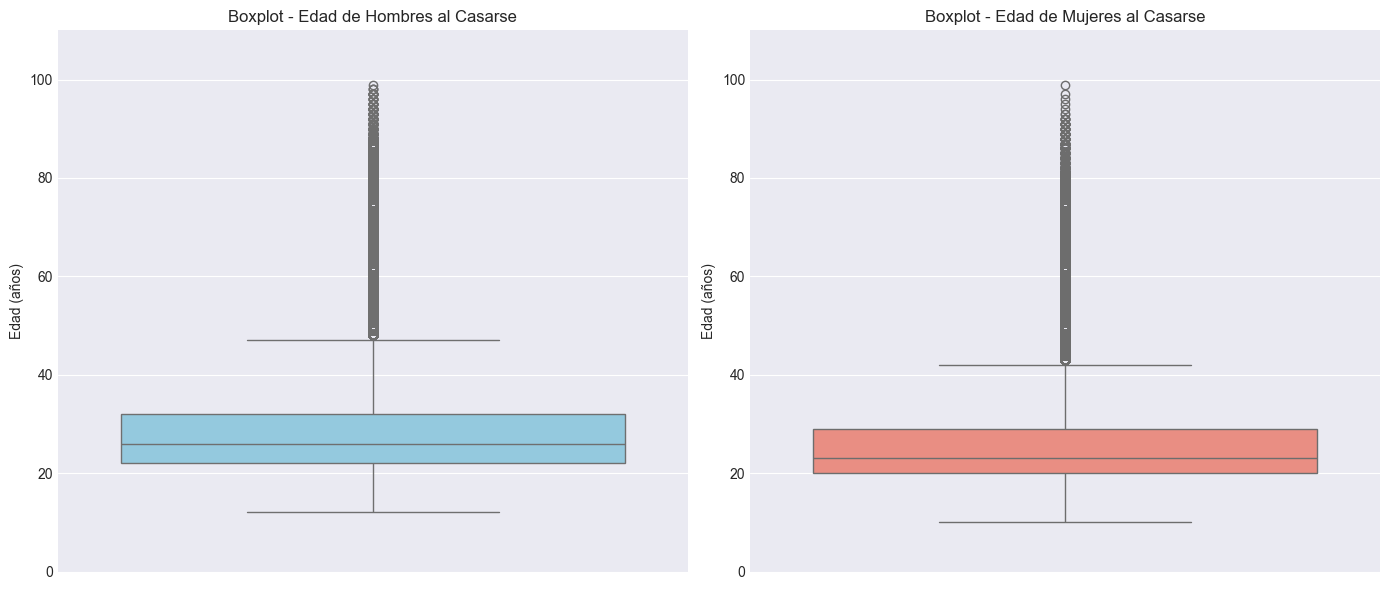

✓ Los boxplots confirman la presencia de valores extremos (círculos) que podrían ser casos reales o errores de codificación (ej. edad 99).


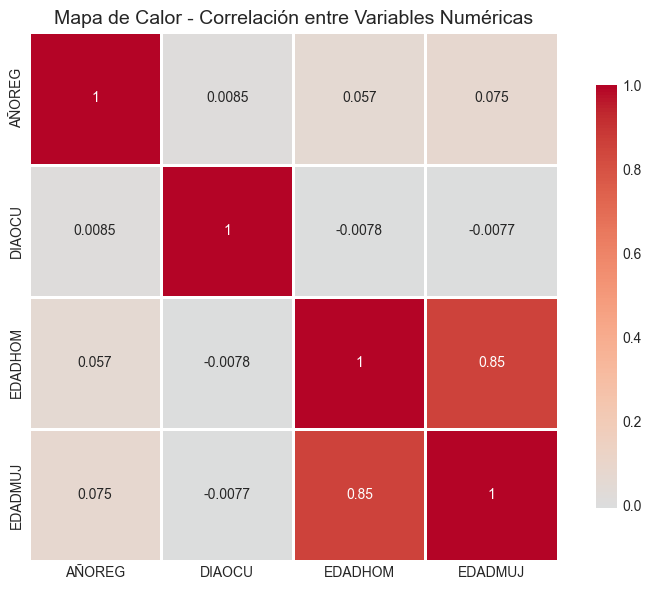

✓ La correlación más fuerte es entre las edades de los cónyuges, lo cual es esperable.


In [14]:
# ============================================================================
# VISUALIZACIÓN DE DISTRIBUCIONES NUMÉRICAS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración de estilo para todos los gráficos
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("VISUALIZACIÓN DE DISTRIBUCIONES NUMÉRICAS")
print("=" * 80)

# --- 1. Histogramas de Edades (Hombres vs Mujeres) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Edad de Hombres
sns.histplot(df['EDADHOM'].dropna(), bins=40, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Edad de Hombres al Casarse', fontsize=12)
axes[0].set_xlabel('Edad (años)')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(df['EDADHOM'].mean(), color='red', linestyle='--', label=f'Media: {df["EDADHOM"].mean():.1f}')
axes[0].axvline(df['EDADHOM'].median(), color='green', linestyle='-', label=f'Mediana: {df["EDADHOM"].median():.1f}')
axes[0].legend()

# Edad de Mujeres
sns.histplot(df['EDADMUJ'].dropna(), bins=40, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribución de Edad de Mujeres al Casarse', fontsize=12)
axes[1].set_xlabel('Edad (años)')
axes[1].set_ylabel('Frecuencia')
axes[1].axvline(df['EDADMUJ'].mean(), color='red', linestyle='--', label=f'Media: {df["EDADMUJ"].mean():.1f}')
axes[1].axvline(df['EDADMUJ'].median(), color='green', linestyle='-', label=f'Mediana: {df["EDADMUJ"].median():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print("✓ Análisis: La distribución de edades es asimétrica positiva (sesgada a la derecha). Los hombres tienden a casarse a edades ligeramente mayores que las mujeres.")

# --- 2. Boxplots de Edades para detectar outliers ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot Edad Hombres
sns.boxplot(y=df['EDADHOM'], ax=axes[0], color='skyblue')
axes[0].set_title('Boxplot - Edad de Hombres al Casarse', fontsize=12)
axes[0].set_ylabel('Edad (años)')
axes[0].set_ylim(0, 110)

# Boxplot Edad Mujeres
sns.boxplot(y=df['EDADMUJ'], ax=axes[1], color='salmon')
axes[1].set_title('Boxplot - Edad de Mujeres al Casarse', fontsize=12)
axes[1].set_ylabel('Edad (años)')
axes[1].set_ylim(0, 110)

plt.tight_layout()
plt.show()
print("✓ Los boxplots confirman la presencia de valores extremos (círculos) que podrían ser casos reales o errores de codificación (ej. edad 99).")

# --- 3. Heatmap de Correlación entre variables numéricas ---
plt.figure(figsize=(8, 6))
df_numeric_corr = df_numeric.corr()
sns.heatmap(df_numeric_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Mapa de Calor - Correlación entre Variables Numéricas', fontsize=14)
plt.tight_layout()
plt.show()
print("✓ La correlación más fuerte es entre las edades de los cónyuges, lo cual es esperable.")


VISUALIZACIÓN DE VARIABLES CATEGÓRICAS


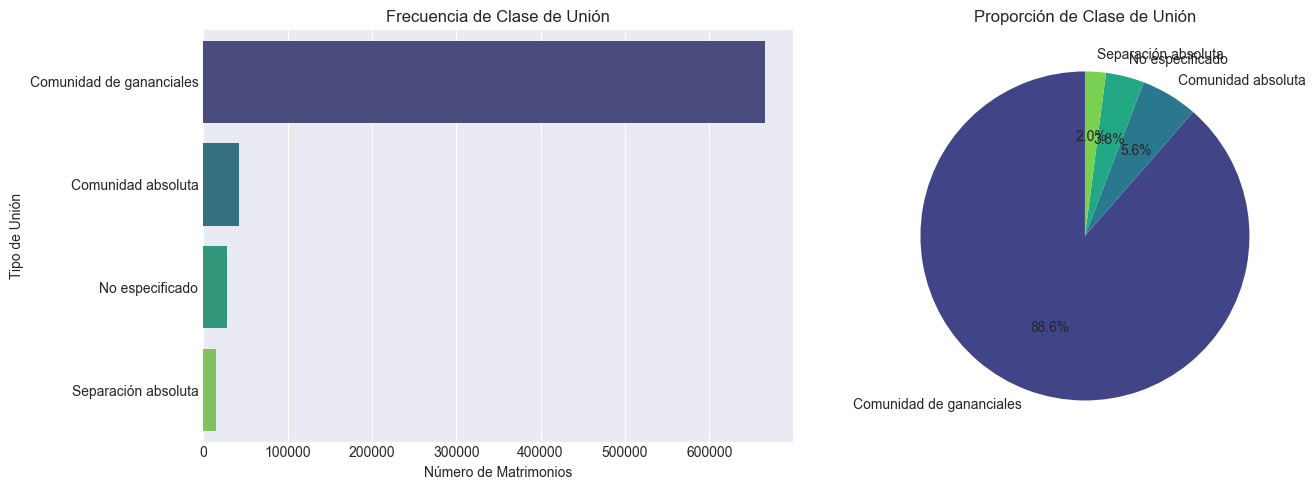

✓ 'Comunidad de gananciales' es el régimen matrimonial predominante (88.6%).


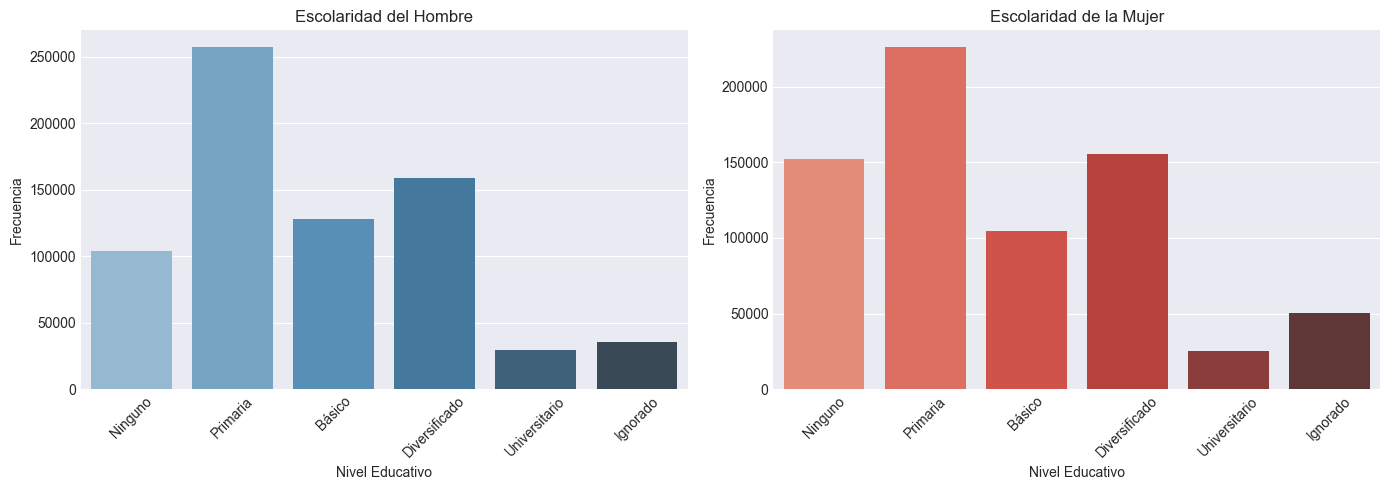

✓ Primaria es el nivel más frecuente en ambos, pero las mujeres tienen mayor proporción en 'Ninguno'.


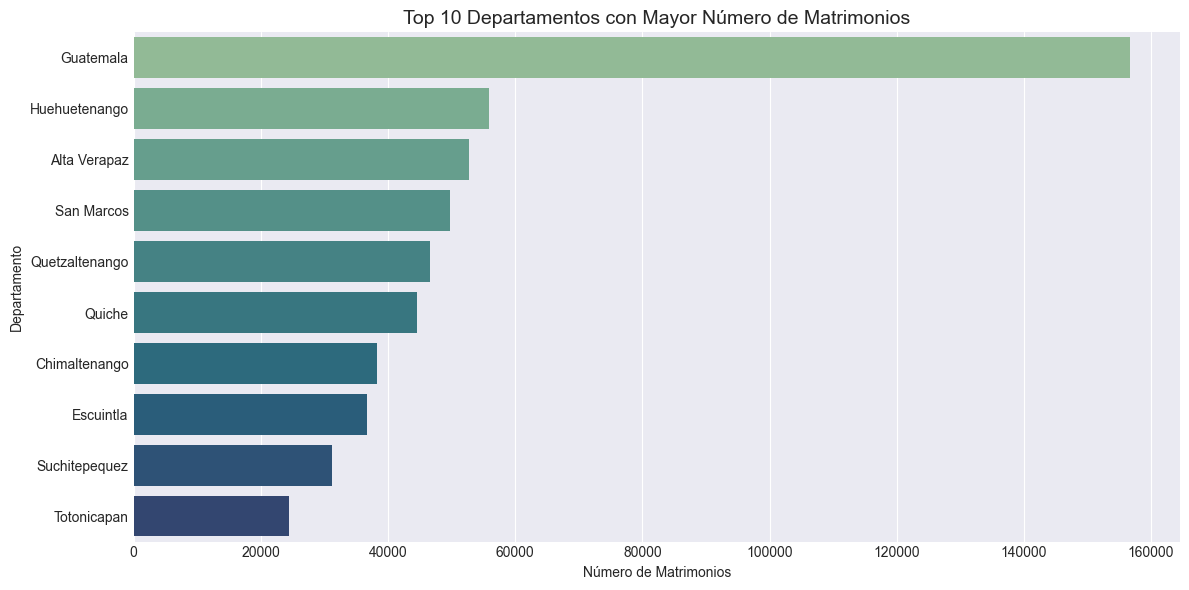

✓ Guatemala concentra el 20.8% de los matrimonios.


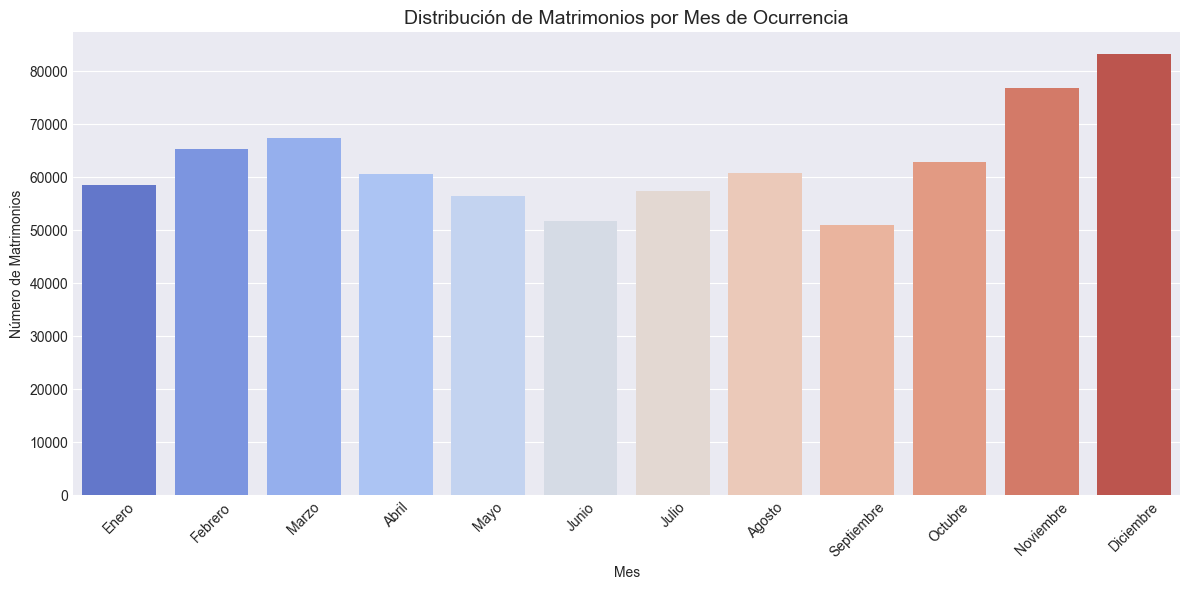

✓ Diciembre y Noviembre son los meses con más matrimonios, mostrando una clara estacionalidad.


In [15]:
# ============================================================================
# VISUALIZACIÓN DE VARIABLES CATEGÓRICAS CLAVE
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZACIÓN DE VARIABLES CATEGÓRICAS")
print("=" * 80)

# --- 1. Clase de Unión (CLAUNI) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
clauni_counts = df['CLAUNI'].value_counts()
sns.barplot(x=clauni_counts.values, y=clauni_counts.index, ax=axes[0], palette='viridis')
axes[0].set_title('Frecuencia de Clase de Unión', fontsize=12)
axes[0].set_xlabel('Número de Matrimonios')
axes[0].set_ylabel('Tipo de Unión')

# Gráfico de pastel (para proporciones)
axes[1].pie(clauni_counts.values, labels=clauni_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('viridis', len(clauni_counts)))
axes[1].set_title('Proporción de Clase de Unión', fontsize=12)

plt.tight_layout()
plt.show()
print("✓ 'Comunidad de gananciales' es el régimen matrimonial predominante (88.6%).")

# --- 2. Escolaridad (Comparación Hombre vs Mujer) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Escolaridad Hombres (ordenada)
orden_educativo = ['Ninguno', 'Primaria', 'Básico', 'Diversificado', 'Universitario', 'Ignorado']
eschom_counts = df['ESCHOM'].value_counts().reindex(orden_educativo, fill_value=0)
sns.barplot(x=eschom_counts.index, y=eschom_counts.values, ax=axes[0], palette='Blues_d')
axes[0].set_title('Escolaridad del Hombre', fontsize=12)
axes[0].set_xlabel('Nivel Educativo')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=45)

# Escolaridad Mujeres
escmuj_counts = df['ESCMUJ'].value_counts().reindex(orden_educativo, fill_value=0)
sns.barplot(x=escmuj_counts.index, y=escmuj_counts.values, ax=axes[1], palette='Reds_d')
axes[1].set_title('Escolaridad de la Mujer', fontsize=12)
axes[1].set_xlabel('Nivel Educativo')
axes[1].set_ylabel('Frecuencia')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
print("✓ Primaria es el nivel más frecuente en ambos, pero las mujeres tienen mayor proporción en 'Ninguno'.")

# --- 3. Top 10 Departamentos de Registro ---
plt.figure(figsize=(12, 6))
top10_dep = df['DEPREG'].value_counts().head(10)
sns.barplot(x=top10_dep.values, y=top10_dep.index, palette='crest')
plt.title('Top 10 Departamentos con Mayor Número de Matrimonios', fontsize=14)
plt.xlabel('Número de Matrimonios')
plt.ylabel('Departamento')
plt.tight_layout()
plt.show()
print(f"✓ Guatemala concentra el {top10_dep.values[0]/len(df)*100:.1f}% de los matrimonios.")

# --- 4. Estacionalidad: Meses de Ocurrencia ---
plt.figure(figsize=(12, 6))
orden_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
mesocu_counts = df['MESOCU'].value_counts().reindex(orden_meses)

sns.barplot(x=mesocu_counts.index, y=mesocu_counts.values, palette='coolwarm')
plt.title('Distribución de Matrimonios por Mes de Ocurrencia', fontsize=14)
plt.xlabel('Mes')
plt.ylabel('Número de Matrimonios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("✓ Diciembre y Noviembre son los meses con más matrimonios, mostrando una clara estacionalidad.")


ANÁLISIS DE RELACIONES ENTRE VARIABLES


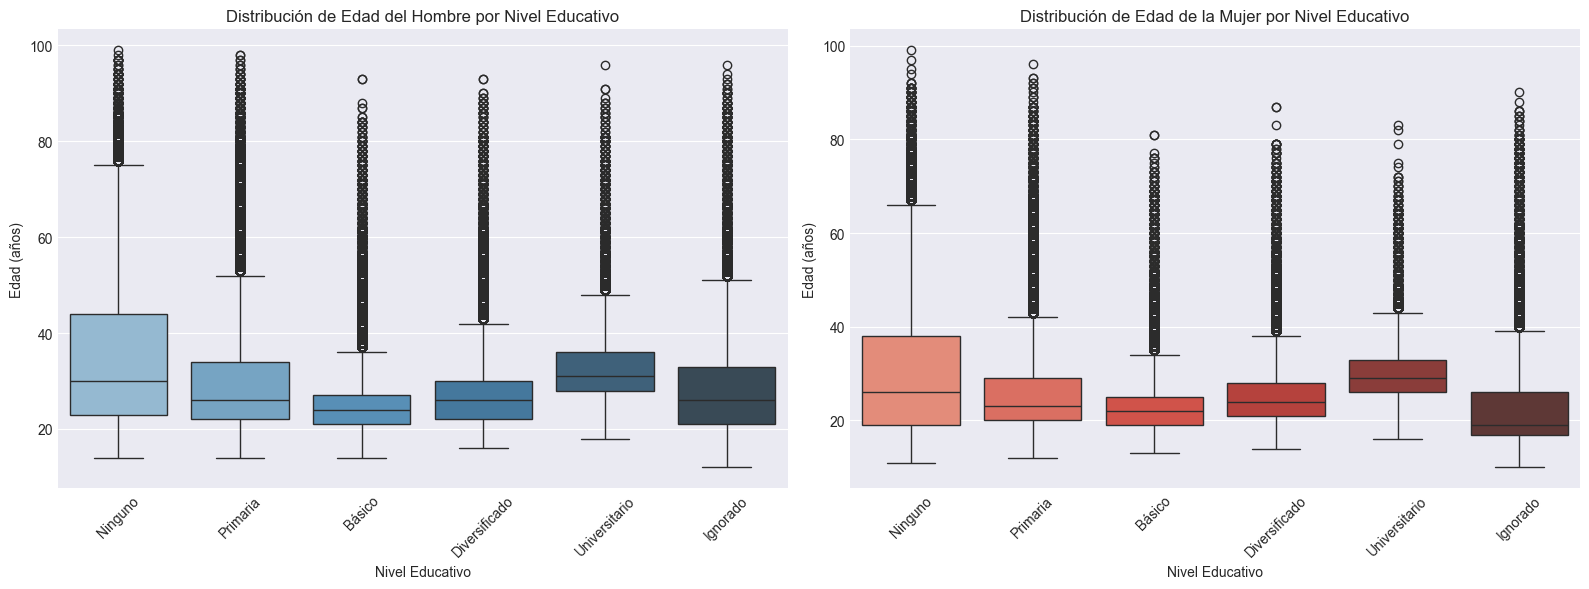

✓ A mayor nivel educativo, la edad al casarse tiende a ser mayor (especialmente en universitarios).


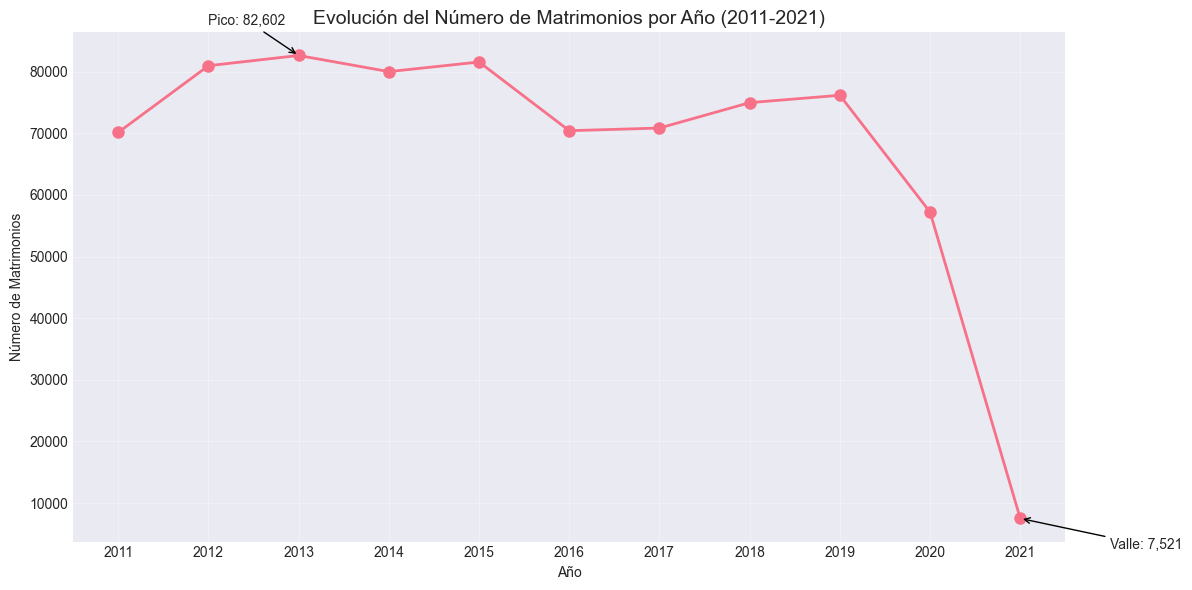

✓ Se observa una tendencia creciente hasta 2019, con una caída en 2020-2021 (posible efecto pandemia).


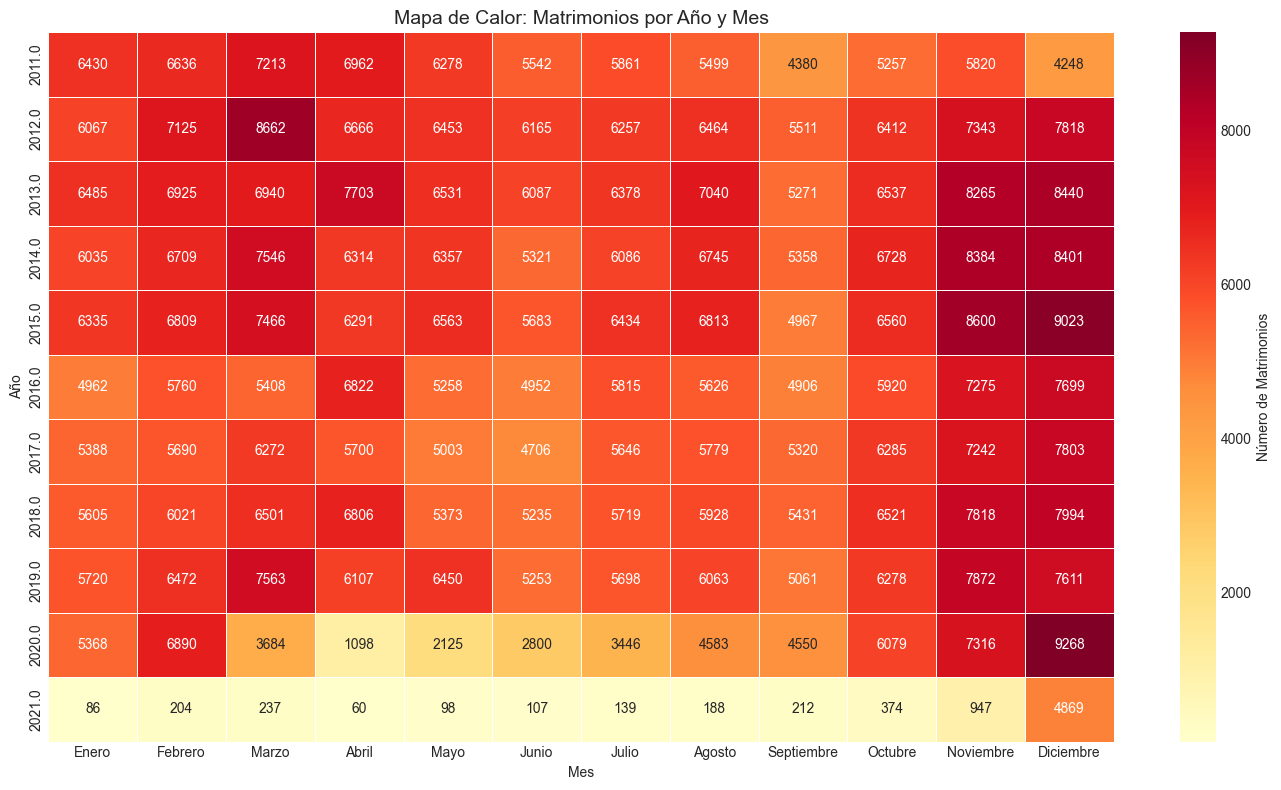

✓ El heatmap confirma que diciembre es consistentemente el mes con más matrimonios a lo largo de todos los años.


In [16]:
# ============================================================================
# ANÁLISIS DE RELACIONES ENTRE VARIABLES
# ============================================================================

print("\n" + "=" * 80)
print("ANÁLISIS DE RELACIONES ENTRE VARIABLES")
print("=" * 80)

# --- 1. Boxplots de Edad por Nivel Educativo (Hombre) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Filtrar datos válidos y ordenar
df_educ_hom = df[df['ESCHOM'].isin(orden_educativo)].copy()

sns.boxplot(x='ESCHOM', y='EDADHOM', data=df_educ_hom, ax=axes[0], 
            order=orden_educativo, palette='Blues_d')
axes[0].set_title('Distribución de Edad del Hombre por Nivel Educativo', fontsize=12)
axes[0].set_xlabel('Nivel Educativo')
axes[0].set_ylabel('Edad (años)')
axes[0].tick_params(axis='x', rotation=45)

# Boxplots de Edad por Nivel Educativo (Mujer)
df_educ_muj = df[df['ESCMUJ'].isin(orden_educativo)].copy()
sns.boxplot(x='ESCMUJ', y='EDADMUJ', data=df_educ_muj, ax=axes[1],
            order=orden_educativo, palette='Reds_d')
axes[1].set_title('Distribución de Edad de la Mujer por Nivel Educativo', fontsize=12)
axes[1].set_xlabel('Nivel Educativo')
axes[1].set_ylabel('Edad (años)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
print("✓ A mayor nivel educativo, la edad al casarse tiende a ser mayor (especialmente en universitarios).")

# --- 2. Evolución Temporal de Matrimonios ---
años_ordenados = sorted(df['AÑOREG'].dropna().unique())
conteo_años = df['AÑOREG'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(conteo_años.index, conteo_años.values, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('Evolución del Número de Matrimonios por Año (2011-2021)', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Número de Matrimonios')
plt.grid(True, alpha=0.3)
plt.xticks(años_ordenados)

# Destacar el pico y el valle
max_año = conteo_años.idxmax()
min_año = conteo_años.idxmin()
plt.annotate(f'Pico: {conteo_años.max():,}', xy=(max_año, conteo_años.max()), 
             xytext=(max_año-1, conteo_años.max()+5000),
             arrowprops=dict(arrowstyle='->'))
plt.annotate(f'Valle: {conteo_años.min():,}', xy=(min_año, conteo_años.min()),
             xytext=(min_año+1, conteo_años.min()-5000),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()
print("✓ Se observa una tendencia creciente hasta 2019, con una caída en 2020-2021 (posible efecto pandemia).")

# --- 3. Heatmap: Matrimonios por Año y Mes ---
# Crear tabla pivote
pivot_meses = pd.crosstab(df['AÑOREG'], df['MESOCU'])
pivot_meses = pivot_meses[orden_meses]  # Ordenar meses correctamente

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_meses, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Número de Matrimonios'})
plt.title('Mapa de Calor: Matrimonios por Año y Mes', fontsize=14)
plt.xlabel('Mes')
plt.ylabel('Año')
plt.tight_layout()
plt.show()
print("✓ El heatmap confirma que diciembre es consistentemente el mes con más matrimonios a lo largo de todos los años.")